### Importing the dependencies to work with

In [94]:
import lmfit
from lmfit.models import GaussianModel
import rampy as rp #Charles' libraries and functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

###  Reading the data file

In [95]:
# Load Data
filename = 'Data/qg27_thyl_XY10'
data = pd.read_csv(filename, delimiter = "\t", names=["x", "y"])

### Visualize the Data

In [96]:
fig = px.line(data_frame=data, x=data['x'], y=data['y'])
fig.show()

In [97]:
# Convert Dataframe data to numpy arrays for working with smoothening and correction
data_array = data.to_numpy()
x = data_array[:,0]
y = data_array[:,1]


Incase you want to smooth

In [98]:
# Incase to smooth
# y_smo = rp.smooth(data_array[:,0],data_array[:,1],method="savgol",window_length=5,polyorder=3)
# y_smo = rp.smooth(x,y,method="whittaker",Lambda=10**0.5)

 Incase you want to check the smoothen and raw data

In [99]:
# Check the plots before and after smooth
# plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
# plt.plot(x, y)
# plt.title("Raw Data")
# plt.subplot(2,1,2)
# plt.title("Smoothen Data")
# plt.plot(data_array[:,0], y_smo)

#### Select the region of Interest (ROI)

In [100]:
roi = np.array([(1347,1365),(1774,1800)])
roi[1,1]

1800

### Baseline Fitting and trimming the data

In [101]:
# Base line correction
y_corr, y_base = rp.baseline(x,y,roi,'poly',polynomial_order=3)

# Trim the data
x_fit = x[np.where((x > roi[0,0])&(x < roi[1,1]))]
y_fit = y_corr[np.where((x > roi[0,0])&(x < roi[1,1]))]

Plot the trimmed data

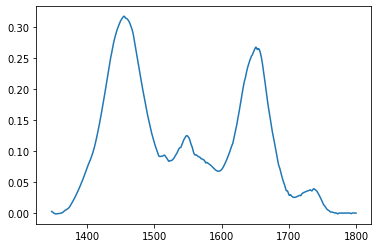

In [102]:
plt.figure()
plt.plot(x_fit,y_fit)
# plt.xlim([1347,1849])
# plt.title("Trimmed Data non-normalized")

Normalized the trimmed data and plot

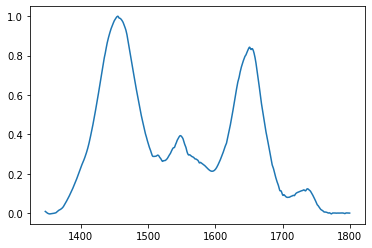

In [103]:
y_fit_norm_intensity = rp.normalise(y_fit,x=x_fit,method="intensity")
plt.plot(x_fit,y_fit_norm_intensity)
# plt.title("Trimmed Data normalized to max intensity")

If you want to use the normalized data for rest of your work use that variable accordingly, for example, y_fit_norm_intensity is for nomalized data and y_fit is for non normalized data

More on residuals from this fit

In [104]:
# ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
# print(ese0)
# y_fit[:,0] = y_fit[:,0]/np.amax(y_fit[:,0])*10 # normalise spectra to maximum intensity, easier to handle 

# sigma = abs(ese0*y_fit[:,0]) #calculate good ese
# sigma

Text(0.5, 1.0, 'B) signal to fit')

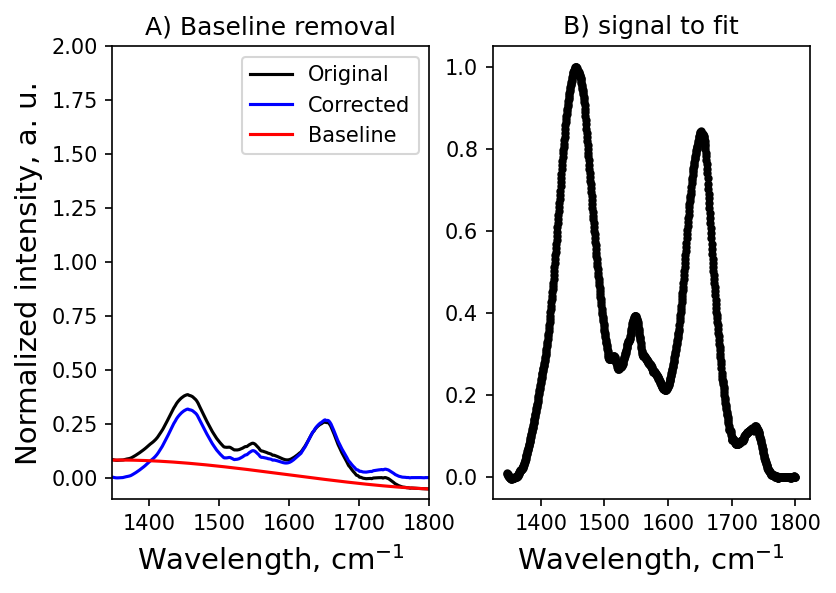

In [105]:
# create a new plot for showing the spectrum
plt.figure(dpi=150)
plt.subplot(1,2,1)
inp = plt.plot(x,y,'k-',label='Original')
corr = plt.plot(x,y_corr,'b-',label='Corrected') #we use the sample variable because it is not already normalized...
bas = plt.plot(x,y_base,'r-',label='Baseline')
plt.xlim(roi[0,0],roi[1,1])
plt.ylim(-0.1,2)
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.legend()
plt.title('A) Baseline removal')

plt.subplot(1,2,2)
plt.plot(x_fit,y_fit_norm_intensity,'k.')
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.title('B) signal to fit')
#plt.tight_layout()
# plt.suptitle('Figure 2', fontsize = 14,fontweight = 'bold')

### Helper Function 

In [106]:
def residual(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    a1 = pars['a1'].value
    a2 = pars['a2'].value
    a3 = pars['a3'].value
    a4 = pars['a4'].value
    a5 = pars['a5'].value
    a6 = pars['a6'].value
    a7 = pars['a7'].value
    
    f1 = pars['f1'].value
    f2 = pars['f2'].value
    f3 = pars['f3'].value
    f4 = pars['f4'].value
    f5 = pars['f5'].value 
    f6 = pars['f6'].value
    f7 = pars['f7'].value
    
    l1 = pars['l1'].value
    l2 = pars['l2'].value
    l3 = pars['l3'].value
    l4 = pars['l4'].value
    l5 = pars['l5'].value
    l6 = pars['l6'].value
    l7 = pars['l7'].value
    
    
    # Using the Gaussian model function from rampy
    peak1 = rp.lorentzian(x,a1,f1,l1)
    peak2 = rp.lorentzian(x,a2,f2,l2)
    peak3 = rp.lorentzian(x,a3,f3,l3)
    peak4 = rp.lorentzian(x,a4,f4,l4)
    peak5 = rp.lorentzian(x,a5,f5,l5)
    peak6 = rp.lorentzian(x,a6,f6,l6)
    peak7 = rp.lorentzian(x,a7,f7,l7)
    
    model = peak1 + peak2 + peak3 + peak4 + peak5 + peak6 + peak7 # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1, peak2, peak3, peak4, peak5, peak6, peak7
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

Quick check for the input paramaters 

In [107]:
arr = np.column_stack((x_fit,y_fit_norm_intensity))
my_array = pd.DataFrame(arr, columns = ['x_fit','y_fit'])
fig = px.line(data_frame=my_array, x=my_array['x_fit'], y=my_array['y_fit'])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

It would be good to check the plot and assign initial parameters in the parameters section for good and faster fit.

### Parameters Section

Make sure to add equal number of parameters as you have used in case of the residual local function . 

In [108]:
# params = lmfit.Parameters()
# algo = 'leastsq'
# #               (Name,  Value,   Vary,   Min,     Max,       Expr)
# params.add_many(('a1',   0.56,    True,    0,       1,      None),    #Amplitude
#                 ('f1',   1455,   True,   1440,    1480,     None), #position
#                 ('l1',   26,     True,     0,      100,     None), # FWHM
#                 ('a2',   0.26,   True,     0,      1,       None),   #Amplitude
#                 ('f2',   1515,   True,   1509,    1522,     None),
#                 ('l2',    5,     True,    0,      50,       None),  
#                 ('a3',   0.47,    True,    0,      1,       None),  # Amplitude
#                 ('f3',   1551,   True,    1540,   1571,     None),
#                 ('l3',   20,     True,     10,     60,      None),  
#                 ('a4',   0.9,    True,      0,      1,      None), # Amplitude
#                 ('f4',   1650,   True,   1635,    1660,     None),
#                 ('l4',   45,     True,     20,     80,      None),  
#                 ('a5',   0.08,    True,   0.0,     1,       None), # Amplitude
#                 ('f5',   1736,   True,    1730,    1750,    None),
#                 ('l5',   20,     True,     0,      60,      None),
#                 ('a6',   0.8,    True,     0.0,       1,    None), # Amplitude
#                 ('f6',   1655,   True,    1645,    1660,    None),
#                 ('l6',   20,     True,     0,      25,      None),   
#                 ('a7',   0.1,    True,     0.0,       1,    None), # Amplitude
#                 ('f7',   1397,   True,    1380,    1471,    None),
#                 ('l7',   20,     True,     0,      50,      None),   
                        
#                )
# params               

In [109]:
params = lmfit.Parameters()
algo = 'leastsq'
#               (Name,  Value,   Vary,   Min,     Max,       Expr)
params.add_many(
                # Protein
                ('a1',   0.1,    True,    0,       0.09,      None),    #Amplitude
                ('f1',   1740,   True,   1720,    1755,     None), #position
                ('l1',   5,     True,     0,      40,       None), # FWHM

                ('a2',   0.1,   True,     0,      1,        None),   #Amplitude
                ('f2',   1725,   True,   1705,   1745,      None),
                ('l2',    10,     True,    0,      50,       None), 
                # Lipid
                ('a3',   0.9,    True,    0,      1,       None),  # Amplitude
                ('f3',   1654,   True,    1640,   1660,     None),
                ('l3',   20,     True,     10,     40,      None),

                ('a4',   0.9,    True,      0,      1,      None), # Amplitude
                ('f4',   1636,   True,   1630,    1650,     None),
                ('l4',   20,     True,     10,     80,      None), 
                
                ####
                ('a5',   0.3,    True,    0.0,     1,       None), # Amplitude
                ('f5',   1547,   True,    1592,    1505,    None),
                ('l5',   40,     True,     0,      100,     None),

                ('a6',   0.7,    True,     0.0,       1,    None), # Amplitude
                ('f6',   1453,   True,    1425,    1470,    None),
                ('l6',   20,     True,     0,      50,      None),   
                
                ('a7',   0.07,    True,     0.0,       1,    None), # Amplitude
                ('f7',   1367,   True,    1350,    1400,    None),
                ('l7',   20,     True,     0,      50,      None),   
                        
               )
params  

name,value,initial value,min,max,vary
a1,0.09000000,0.1,0.00000000,0.09000000,True
f1,1740.00000,1740,1720.00000,1755.00000,True
l1,5.00000000,5,0.00000000,40.0000000,True
a2,0.10000000,0.1,0.00000000,1.00000000,True
f2,1725.00000,1725,1705.00000,1745.00000,True
l2,10.0000000,10,0.00000000,50.0000000,True
a3,0.90000000,0.9,0.00000000,1.00000000,True
f3,1654.00000,1654,1640.00000,1660.00000,True
l3,20.0000000,20,10.0000000,40.0000000,True
a4,0.90000000,0.9,0.00000000,1.00000000,True


In [110]:
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit_norm_intensity[:,0]))


### Run Fit

In [111]:
# result2 = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit_norm_intensity[:,0]))
print(lmfit.fit_report(result))
model = lmfit.fit_report(result.params)
print(model)
# to_print = lmfit.fit_report(result)
# to_print

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 246
    # data points      = 940
    # variables        = 21
    chi-square         = 1.29465721
    reduced chi-square = 0.00140877
    Akaike info crit   = -6150.37588
    Bayesian info crit = -6048.61240
[[Variables]]
    a1:  0.07161186 +/- 0.01485816 (20.75%) (init = 0.09)
    f1:  1738.81100 +/- 1.03660664 (0.06%) (init = 1740)
    l1:  4.18991958 +/- 1.65672118 (39.54%) (init = 5)
    a2:  0.04569191 +/- 0.01565163 (34.25%) (init = 0.1)
    f2:  1728.40591 +/- 1.55223573 (0.09%) (init = 1725)
    l2:  3.95716290 +/- 2.55131833 (64.47%) (init = 10)
    a3:  0.53470518 +/- 0.04938625 (9.24%) (init = 0.9)
    f3:  1658.38957 +/- 0.78734698 (0.05%) (init = 1654)
    l3:  15.7183505 +/- 0.91466011 (5.82%) (init = 20)
    a4:  0.49757885 +/- 0.04395827 (8.83%) (init = 0.9)
    f4:  1638.19605 +/- 1.30701183 (0.08%) (init = 1636)
    l4:  19.7646301 +/- 1.09533244 (5.54%) (init = 20)
    a5:  0.24068350 +/- 0.

### Get all the residuals

In [112]:
yout, peak1,peak2,peak3,peak4,peak5,peak6, peak7 = residual(result.params,x_fit)


Plot

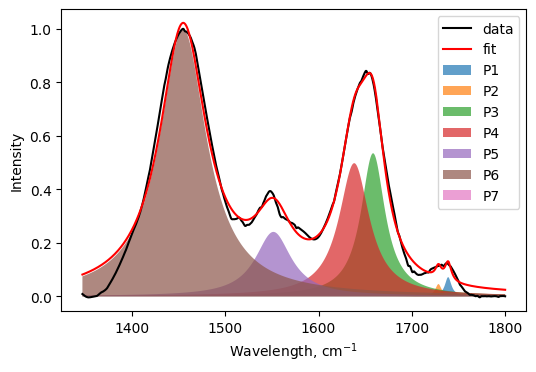

In [113]:
plt.figure(dpi=100)

plt.plot(x_fit,y_fit_norm_intensity,'k', markerfacecolor="None",label = 'data' )
plt.plot(x_fit,yout, 'r',label = 'fit' )
plt.fill_between(x_fit,peak1, alpha=0.7,label = 'P1')
plt.fill_between(x_fit,peak2, alpha=0.7, label = 'P2')
plt.fill_between(x_fit,peak3, alpha=0.7, label = 'P3')
plt.fill_between(x_fit,peak4, alpha=0.7, label = 'P4')
plt.fill_between(x_fit,peak5, alpha=0.7, label = 'P5')
plt.fill_between(x_fit,peak6, alpha=0.7, label = 'P6')
plt.fill_between(x_fit,peak7, alpha=0.7, label = 'P7')
plt.legend(loc="upper right")
plt.xlabel("Wavelength, cm$^{-1}$")
plt.ylabel("Intensity")
# plt.gca().invert_yaxis()

plt.show()

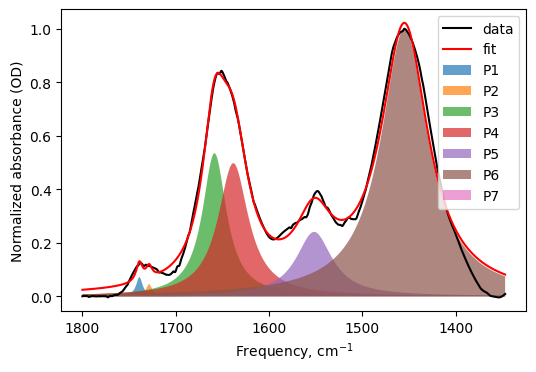

Data/qg27_thyl_XY10


In [114]:
from matplotlib.pyplot import title


plt.figure(dpi=100)

plt.plot(x_fit,y_fit_norm_intensity,'k', markerfacecolor="None",label = 'data' )
plt.plot(x_fit,yout, 'r',label = 'fit' )
plt.fill_between(x_fit,peak1, alpha=0.7,label = 'P1')
plt.fill_between(x_fit,peak2, alpha=0.7, label = 'P2')
plt.fill_between(x_fit,peak3, alpha=0.7, label = 'P3')
plt.fill_between(x_fit,peak4, alpha=0.7, label = 'P4')
plt.fill_between(x_fit,peak5, alpha=0.7, label = 'P5')
plt.fill_between(x_fit,peak6, alpha=0.7, label = 'P6')
plt.fill_between(x_fit,peak7, alpha=0.7, label = 'P7')
# ax = plt.gca()
# ax.title("A")
plt.legend(loc="upper right")
plt.xlabel("Frequency, cm$^{-1}$")
plt.ylabel("Normalized absorbance (OD)")
# plt.plot.title("Trimmed")
plt.gca().invert_xaxis()
plt.show()
print(filename)

In [119]:
# Area under curve calculation
from scipy.integrate import trapz

a_p1 = trapz(peak1,x_fit)
a_p2 = trapz(peak2,x_fit)
print(a_p1)
print(a_p2)
sum_lipid = a_p1+a_p2
print(sum_lipid)

a_p3 = trapz(peak3,x_fit)
a_p4 = trapz(peak4,x_fit)

sum_protein = a_p3+a_p4

r = sum_lipid/sum_protein
r

-0.9188489510871434
-0.5561490280071475
-1.4749979790942909


0.027273143690536454

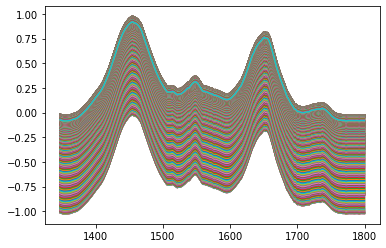

In [116]:
res = y_fit_norm_intensity - yout
plt.plot(x_fit,res)